## Fungi Image Classification

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate, ShuffleSplit
from sklearn import preprocessing

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add, MaxPool2D
import keras
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, AdamW
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import learning_curve
import joblib
import collections
from sklearn.metrics import classification_report, confusion_matrix

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

#project_path = 'Defungi_S'
project_path = 'Defungi'
#project_path = 'Defungi_Preprocessing'
project_seed = 42
project_image_size = (32,32)
#project_image_size = (64,64)
#project_image_size = (128,128)
#project_image_size = (500,500)
project_filter_size = 256
project_batch_size = 32
#project_batch_size = 128
project_epochs = 4;
project_folds = 2;
project_split = 0.1;
project_learning_rate = 0.001
project_auto = tf.data.AUTOTUNE

Tensorflow Version: 2.14.0
Keras Version: 2.14.0


### Preprocessing the Data and Organizing as a csv-file

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def plot_image(image_path):
    cur_img = mpimg.imread(image_path)
    plt.imshow(cur_img)
    plt.show()  # Display the image

In [71]:
def variance_of_filtered_image(image_path, ker_edge_detect, is_im_show = 0):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    if is_im_show:
        print(variance)
        plot_image(image_path)
        plt.imshow(img)
        plt.show()  # Display the image
    return variance

In [72]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
    
def compare_images(image_path, ker_edge_detect):
	# compute the mean squared error and structural similarity
	# index for the images
    image  = cv2.imread(image_path)
    imageA = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imageB = cv2.filter2D(src = imageA.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    vec_arg = np.array([m, s])
    return vec_arg

In [73]:
def image_variance(image_path, is_im_show = 0):
    image  = cv2.imread(image_path)
    mean = np.mean(image)
    variance = np.mean((image - mean) ** 2)
    if is_im_show:
        print(image_path)
        print(variance)
        plot_image(image_path)
    return variance

In [74]:
ker_edge_detect_1 = np.array([[-1, -1, -1], 
                              [-1,  8, -1], 
                              [-1, -1, -1]])
ker_edge_detect_2 = np.array([[ 0, -1,  0], 
                              [-1,  4, -1], 
                              [ 0, -1,  0]])
ker_Sobel_x = np.array([[ -1,  0,  1], 
                        [ -2,  0,  2], 
                        [ -1,  0,  1]])
ker_Sobel_y = np.array([[ -1, -2, -1], 
                        [  0,  0,  0], 
                        [  1,  2,  1]])
ker_Sharpen = np.array([[ 0, -1,  0],
                        [-1,  5, -1],
                        [ 0, -1,  0]])
ker_Blurring = 1/9 *  np.array([[1, 1, 1],
                               [1, 1, 1],
                               [1, 1, 1]])

In [22]:
files = [i for i in glob.glob(project_path + "//*//*")]
#np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
fungus_classes = {'H1':0, 'H2':1, 'H3':2, 'H5':3, 'H6':4}
classes = [fungus_classes[labels[i]] for i in range(len(labels))]

variance = [image_variance(image_path_i) for image_path_i in glob.glob(project_path + "//*//*")]
print("Image variance is calculated")
edge_detect_1 = [variance_of_filtered_image(image_path_i, ker_Sobel_x) for image_path_i in glob.glob(project_path + "//*//*")]
print("Variance of filtered image is calculated (Sobel_x)")
edge_detect_2 = [variance_of_filtered_image(image_path_i, ker_Sobel_y) for image_path_i in glob.glob(project_path + "//*//*")]
print("Variance of filtered image is calculated (Sobel_y)")
data = zip(files, labels, classes, variance, edge_detect_1, edge_detect_2,
           variance/max(variance), edge_detect_1/max(edge_detect_1), edge_detect_2/max(edge_detect_2))
dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "Variance",
                                          "Sobel_x", "Sobel_y", "Norm_Variance", "Norm_Sobel_x", "Norm_Sobel_y"])
dataframe.to_csv(project_path + '\Defungi.csv')
print(dataframe)

Image variance is calculated
Variance of filtered image is calculated (Sobel_x)
Variance of filtered image is calculated (Sobel_y)
                         Image Label  Class    Variance     Sobel_x  \
0     Defungi\H1\H1_100a_1.jpg    H1      0  247.598146   59.766566   
1     Defungi\H1\H1_100a_2.jpg    H1      0  193.682238   38.312500   
2     Defungi\H1\H1_100a_3.jpg    H1      0  119.258808   28.891500   
3     Defungi\H1\H1_100a_4.jpg    H1      0  213.663504   51.510539   
4     Defungi\H1\H1_100a_5.jpg    H1      0   70.868878   23.492984   
...                        ...   ...    ...         ...         ...   
9040    Defungi\H6\H6_9a_2.jpg    H6      4  549.215333  548.957832   
9041    Defungi\H6\H6_9a_3.jpg    H6      4  411.474716  383.690084   
9042    Defungi\H6\H6_9a_4.jpg    H6      4  443.044302  230.148846   
9043    Defungi\H6\H6_9a_5.jpg    H6      4  432.228372  400.566107   
9044    Defungi\H6\H6_9a_6.jpg    H6      4  292.189230  255.260052   

         Sobel_y

## The cvs-file Reading and Removing Pictures with the Low Variance 

In [75]:
Defungi_data = pd.read_csv(project_path + '/Defungi.csv')
Quantile = Defungi_data[['Variance','Sobel_x','Sobel_y']].quantile(0.01)

# Drop the blurred datapoints (edges are not clear according to three types of algorithms
# (a simple kernel 8 surrounded by negative ones and two Sobel edges) 
Defungi_data_clear = Defungi_data.loc[(Defungi_data['Variance'] > Quantile['Variance'])]
Defungi_data_blurred = Defungi_data.loc[(Defungi_data['Variance'] <= Quantile['Variance'])]
print(Defungi_data_clear.describe())
print(Defungi_data_blurred.describe())
print(Defungi_data_blurred)
Defungi_data_blurred.to_csv(project_path + '\Defungi_blurred.csv')

       Unnamed: 0.2  Unnamed: 0.1   Unnamed: 0        Class     Variance  \
count   8954.000000   8954.000000  8954.000000  8954.000000  8954.000000   
mean    4538.186844   4538.186844  4538.186844     1.038307   323.211224   
std     2615.414081   2615.414081  2615.414081     1.296528   433.644995   
min        0.000000      0.000000     0.000000     0.000000    14.601621   
25%     2261.250000   2261.250000  2261.250000     0.000000    95.993818   
50%     4557.500000   4557.500000  4557.500000     1.000000   186.273713   
75%     6801.750000   6801.750000  6801.750000     2.000000   336.591704   
max     9044.000000   9044.000000  9044.000000     4.000000  5254.258609   

           Sobel_x      Sobel_y  Norm_Variance  Norm_Sobel_x  Norm_Sobel_y  \
count  8954.000000  8954.000000    8954.000000   8954.000000   8954.000000   
mean     58.412803    58.580427       0.061514      0.049392      0.040960   
std     101.366034    98.688429       0.082532      0.085712      0.069005   
min

In [76]:
def hist_Defungi(df):
    Cat = df["Label"].value_counts()
    print(Cat)
    df["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
    plt.xlabel("Class")
    plt.ylabel("Number of datapoints")
    plt.show()

Label
H1    4404
H2    2265
H3     819
H5     818
H6     739
Name: count, dtype: int64


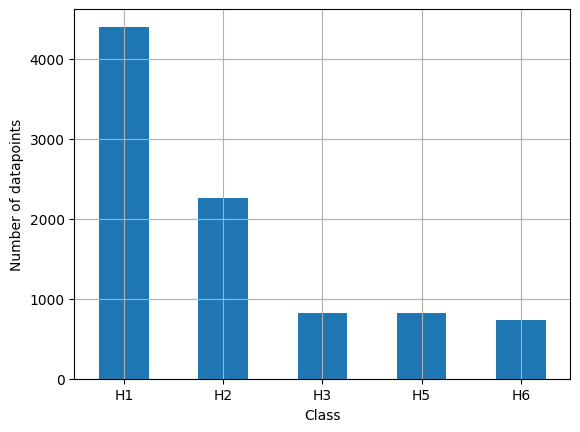

In [77]:
hist_Defungi(Defungi_data)

## Loading Images

In [78]:
# Define a function to load and preprocess an image
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    return image, label

In [79]:
Image_List = Defungi_data_blurred['Image']
Class_List = Defungi_data_blurred['Class']

# Create a TensorFlow dataset from the image and class lists
tf_data_blurred = tf.data.Dataset.from_tensor_slices((Image_List, Class_List))

# Apply the load_image function to each element of the dataset using map
tf_data_blurred = tf_data_blurred.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(tf_data_blurred)

# Create batches from the datasets
tf_data_blurred = tf_data_blurred.batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
tf_data_blurred = tf_data_blurred.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
for image_batch, label_batch in tf_data_blurred.take(15):
    print(image_batch.shape, label_batch)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(32, 32, 32, 3) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)
(32, 32, 32, 3) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)
(27, 32, 32, 3) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2], shape=(27,), dtype=int64)


32
8


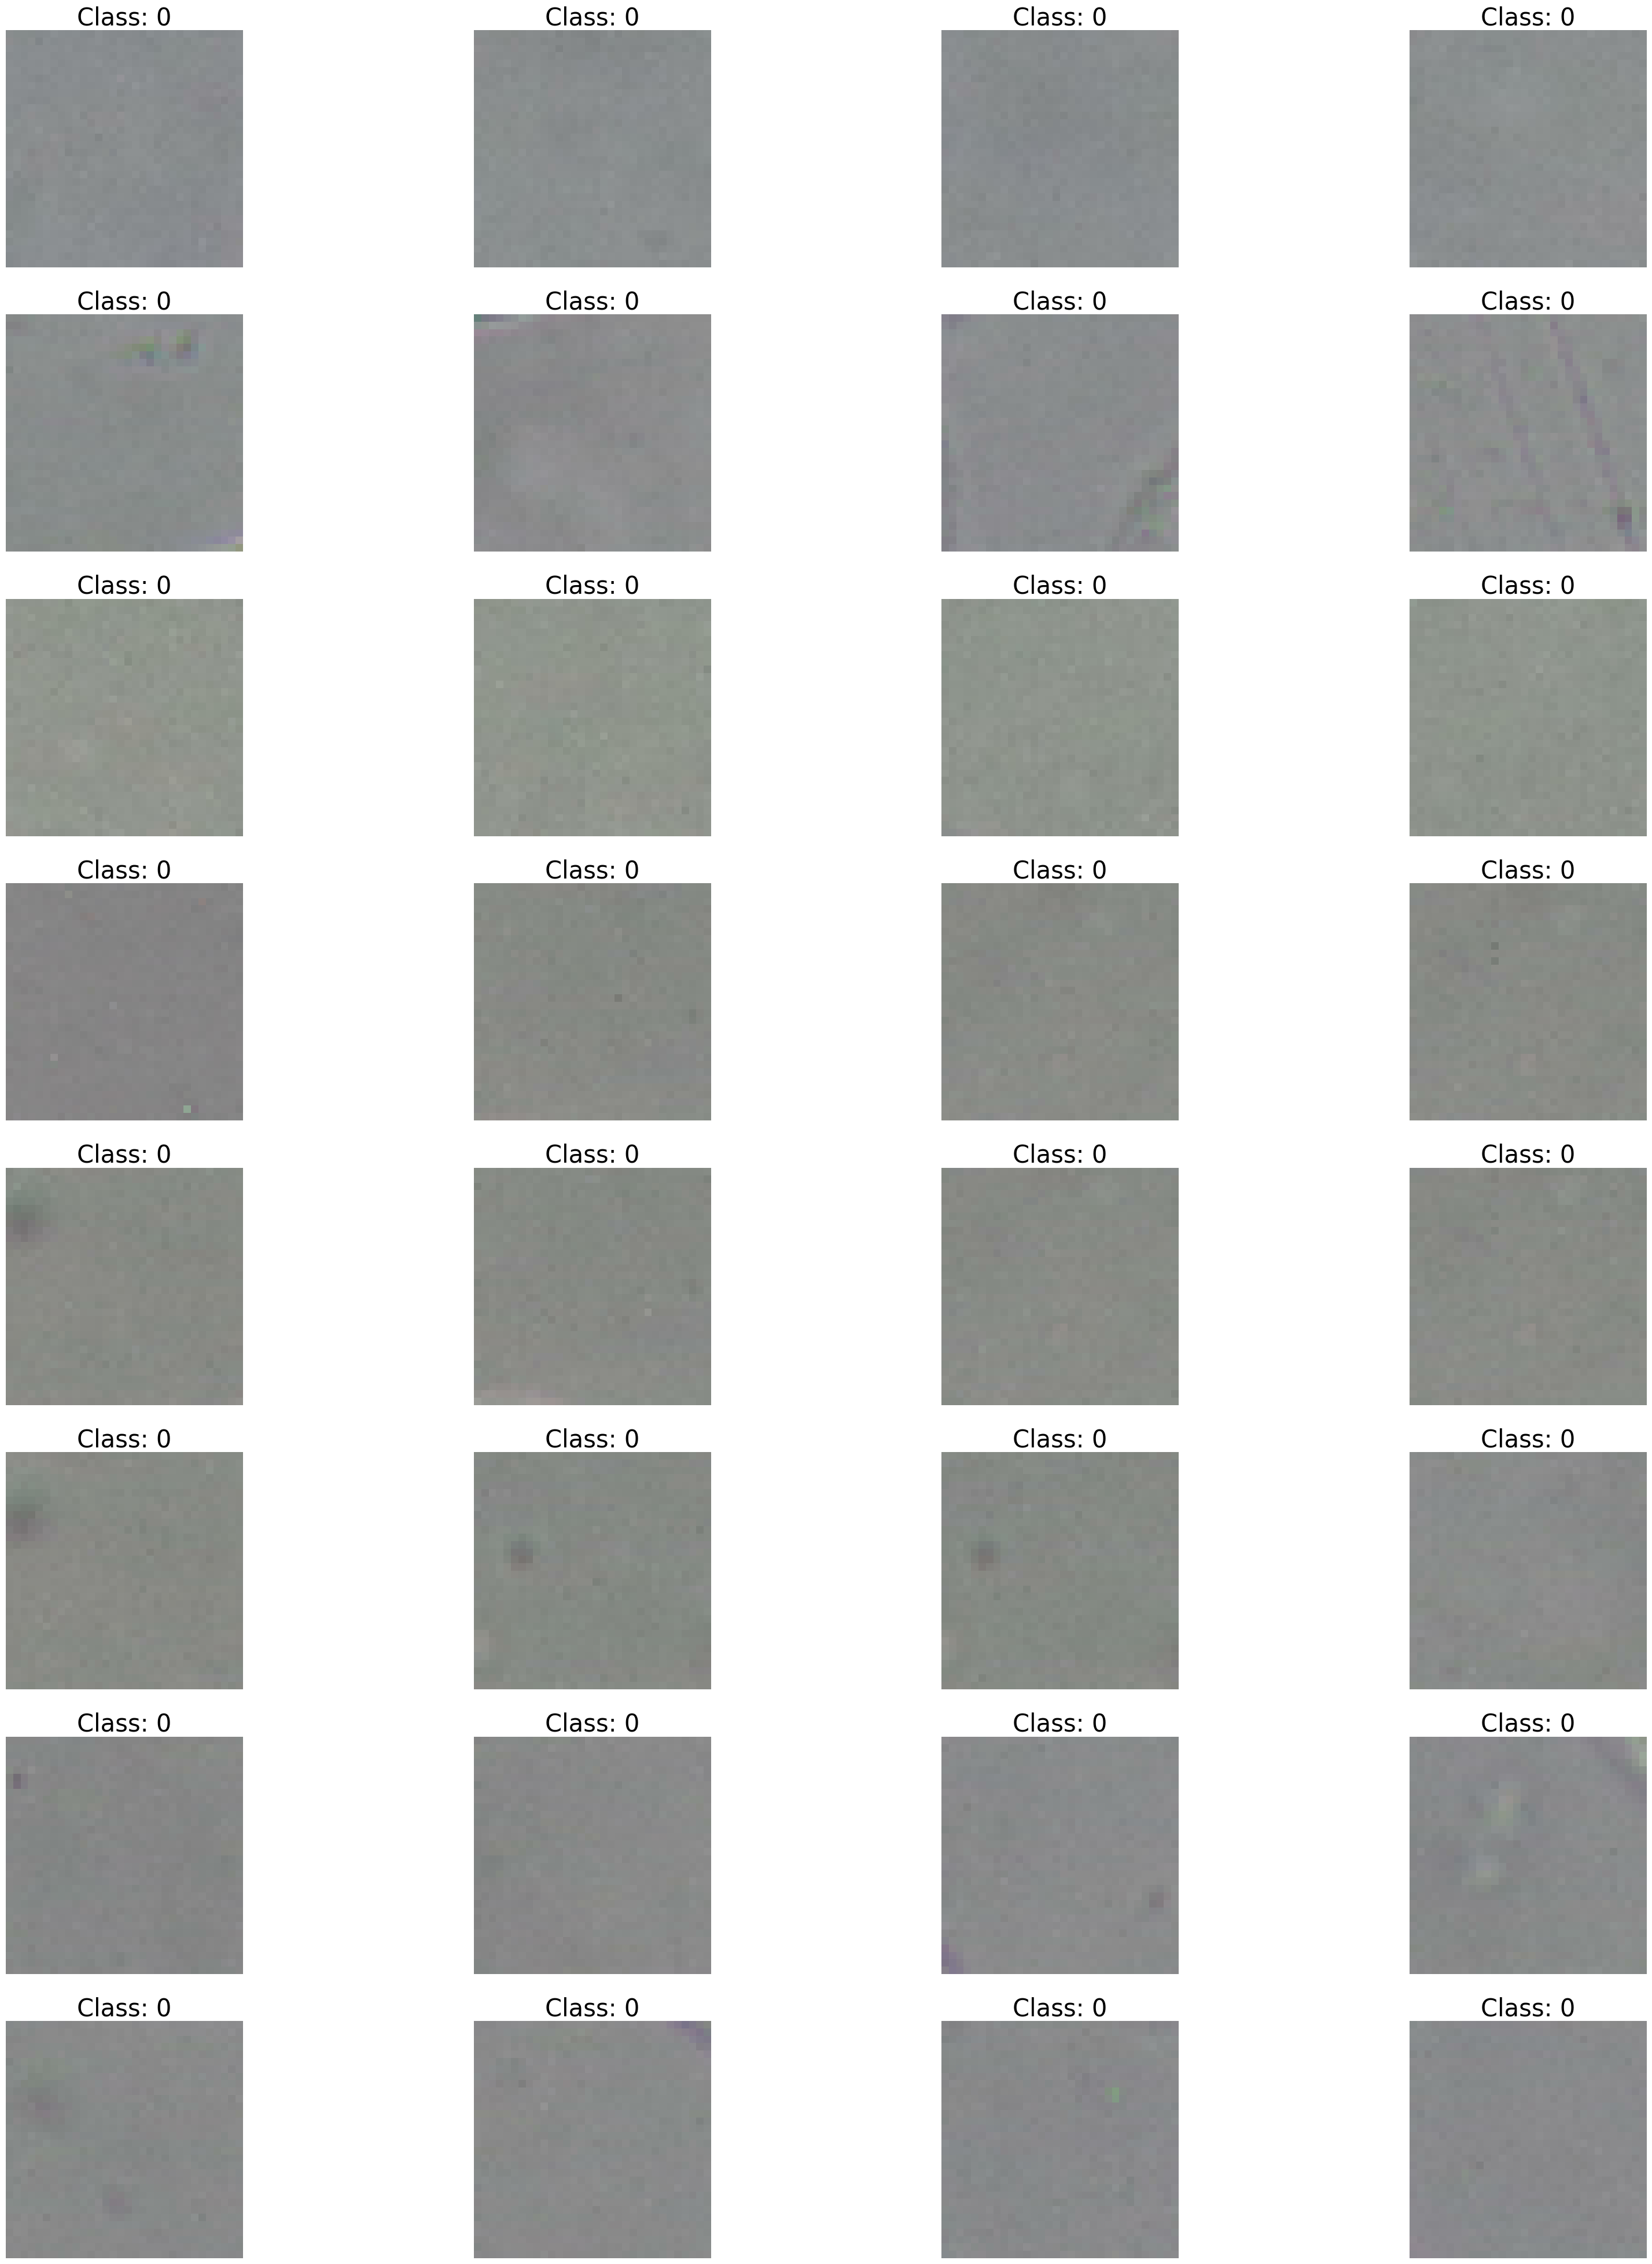

In [81]:
# Display the images
def display_images(df_display):
    data_iterator = df_display.as_numpy_iterator()
    images, labels = data_iterator.next()
    #print(len(images))
    #plt.figure(figsize = (12, 8))
    plt.figure(figsize = (40,50))
    if (len(images) > 32):
        range_for = range(32)
        row_n = 8
    else:
        range_for = range(len(images))
        row_n = round(len(images)/4)
        print(len(images))
        print(row_n)
    for i in range_for:
        plt.subplot(row_n, 4, i + 1)
        plt.imshow(images[i].astype("uint8"))
    #    plt.title(f'Class: {np.argmax(labels[i])}')
        plt.title(f'Class: {labels[i]}', fontsize = 30) 
        plt.axis('off')
    
    plt.show()

display_images(tf_data_blurred)

## Splitting Data

In [122]:
# Group the dataframe by class
Defungi_data_split = Defungi_data_clear.groupby(['Class'])

# Get the groups dictionary
groups = Defungi_data_split.groups

# Initialize the Test_data column with 0
Defungi_data_clear.loc[:,'Test_data'] = 0

# Loop over the classes
for Class in groups:
    # Get a random sample of the rows for each class
    sample = Defungi_data_clear.loc[groups[Class]].sample(frac = project_split)
    # Print the number of rows in the sample
    print(len(sample))
    # Assign 1 to the Test_data column for the sample rows
    Defungi_data_clear.loc[sample.index, 'Test_data'] = 1

print(Defungi_data_clear.groupby(['Test_data']).count())

432
226
82
82
74
           Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Image  Label  Class  \
Test_data                                                                
0                  8058          8058        8058   8058   8058   8058   
1                   896           896         896    896    896    896   

           Variance  Sobel_x  Sobel_y  Norm_Variance  Norm_Sobel_x  \
Test_data                                                            
0              8058     8058     8058           8058          8058   
1               896      896      896            896           896   

           Norm_Sobel_y  Sobel  
Test_data                       
0                  8058   8058  
1                   896    896  


Label
H1    4325
H2    2257
H5     818
H3     815
H6     739
Name: count, dtype: int64


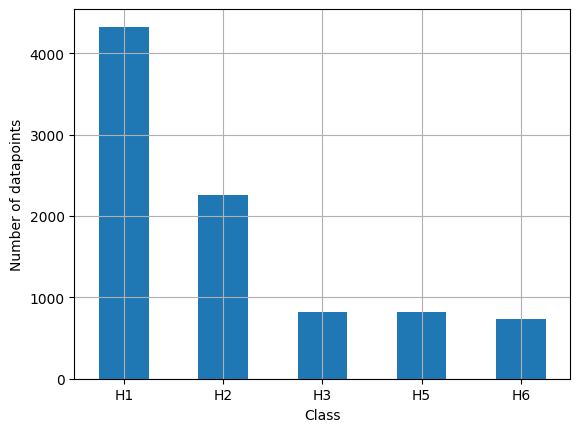

In [123]:
hist_Defungi(Defungi_data_clear)

## Applying Data Augmentation

In [83]:
import imgaug.augmenters as iaa
import numpy as np
import cv2

def augment_function(image):

    # Create a RandomRotation layer
    rotation_layer = tf.keras.layers.RandomRotation(factor = 0.5)  # Factor controls the maximum rotation angle (0.5*360)
    
    # Apply random rotation to an image (assuming 'image' is your input tensor)
    rotated_image = rotation_layer(image)
    return rotated_image
    
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    # If not in the specified classes, return only the original image
    return image, label

In [84]:
def data_augmentation(df):
    X_df = []
    y_df = []

    for images, labels in df:
        label = labels.numpy()
        X_df.extend([images.numpy()])
        y_df.extend([labels.numpy()])
        number_of_aug = 0
        if label == 1:
            number_of_aug = 1
        elif label > 1:
            number_of_aug = 5
        for i in range(1, number_of_aug + 1):
            augmented_image = augment_function(images)
            X_df.extend([augmented_image.numpy()])
            y_df.extend([labels.numpy()])
    return X_df, y_df


In [124]:
# Create a TensorFlow dataset from the image and class lists
data_train = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Image'],
                                                 Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Class']))
# Apply the load_image function to each element of the dataset using map
data_train = data_train.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

X_train, y_train = data_augmentation(data_train)


In [125]:
data_test = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Image'],
                                                Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Class']))

# Apply the load_image function to each element of the dataset using map
data_test = data_test.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(data_test)

X_test, y_test = data_augmentation(data_test)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [126]:
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffling and creating batches from the datasets
data_train = data_train.shuffle(buffer_size = len(X_train)).batch(project_batch_size)
data_test = data_test.shuffle(buffer_size = len(X_test)).batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_test = data_test.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
#for image_batch, image_batch1, label_batch in data_train.take(15):
for image_batch, label_batch in data_test.take(30):
    print(image_batch.shape, label_batch)

# Optional: Shuffle and batch the dataset
#data_train = data_train.shuffle(buffer_size = len(X_train_1)).batch(project_batch_size)

(32, 32, 32, 3) tf.Tensor([0 3 1 3 1 4 0 0 1 1 2 1 4 4 4 0 0 2 2 3 1 0 3 4 0 2 0 1 1 2 1 0], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([4 1 2 4 1 2 0 4 2 3 4 2 2 4 3 0 0 3 0 1 4 3 1 4 1 0 0 3 4 4 2 1], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([2 3 2 2 2 0 4 4 4 3 2 1 3 1 0 2 0 1 1 0 1 0 4 3 3 2 4 3 2 1 1 4], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([4 2 1 1 4 0 2 4 2 4 4 4 1 0 1 2 3 3 0 4 4 3 4 0 3 0 1 2 3 3 2 0], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([0 4 0 1 2 0 0 4 1 3 1 1 3 3 2 4 2 3 3 0 4 1 3 2 2 4 0 3 0 4 0 3], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([4 1 2 4 1 1 2 1 2 4 0 1 4 1 3 4 1 1 2 1 2 3 3 0 1 0 1 4 0 2 1 3], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([0 3 0 0 3 3 4 0 4 2 1 2 4 1 3 0 2 0 2 2 4 4 1 2 0 0 4 4 0 2 1 1], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([0 3 1 4 3 1 1 2 3 2 1 0 1 4 3 1 3 2 4 0 3 3 2 4 0 4 2 1 4 1 2 2], shape=(32,), dtype=int32)
(32, 32, 32, 3) tf.Tensor([3 0 4 1 1 3 1 0 2 2 2

Element counts:
Counter({3: 4908, 2: 4890, 1: 4514, 4: 4434, 0: 4325})


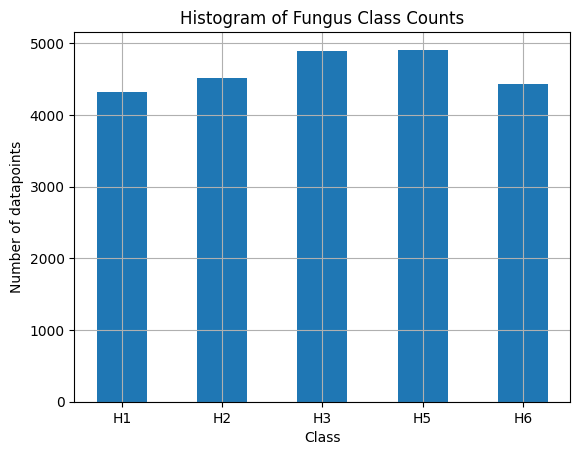

In [127]:
import collections

fungus_classes = {'H1':0, 'H2':1, 'H3':2, 'H5':3, 'H6':4}
class_counts = collections.Counter(np.concatenate((y_train, y_test)))
print("Element counts:")
print(class_counts)

class_names = [class_name for class_name, _ in sorted(fungus_classes.items(), key=lambda x: x[1])]

# Plot the histogram
plt.bar(class_names, class_counts.values(), width = 0.5)
plt.xlabel('Class')
plt.ylabel('Number of datapoints')
plt.title('Histogram of Fungus Class Counts')
plt.grid(True)
plt.show()


In [128]:
print(type(X_train), " ", type(y_train))
print(len(X_train), " ", len(y_train))
print(type(y_test), " ", type(y_test))
print(len(X_test), " ", len(y_test))

<class 'list'>   <class 'list'>
20759   20759
<class 'list'>   <class 'list'>
2312   2312


## Neural Network Models

### ResNet Model

In [227]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
# ResNET-34
augmentation_layer = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

def model_fungi_book(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
#    keras.regularizers.l1_l2(l1=0.01, l2=0.001)
#    x = tf.keras.layers.Rescaling(1/255.0)(inputs)
    x = augmentation_layer(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    residual = x  # Set aside residual
        
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        if filters == prev_filters:
            strides = 1
        else:
            strides = 2
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(residual)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if filters != prev_filters:
            residual = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 1, strides = 4)(residual)
            
        x = tf.keras.layers.add([x, residual])  # Add back residual
        residual = tf.keras.layers.Activation("relu")(x)
        prev_filters = filters
            
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model_386"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_388 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            0         ['input_388[0][0]']           
                                                                                                  
 rescaling_387 (Rescaling)   (None, 32, 32, 3)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d_411 (Conv2D)         (None, 16, 16, 64)           9472      ['rescaling_387[0][0]']       
                                                                                          

### MLP-Mixer Model

In [91]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_conv_mixer(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
    x = tf.keras.layers.Rescaling(1/255.0)(inputs)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 2, strides = 2, padding = "same")(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    vector_of_ones = np.ones(8, dtype = int)
#    print(vector_of_ones)
    kernel_size = 2
    residual = x  # Set aside residual
#    for size in 256 * vector_of_ones:
    for size in filter_size * vector_of_ones:
        x = tf.keras.layers.DepthwiseConv2D(kernel_size = kernel_size, strides = 1, padding = 'same')(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Conv2D(filters = size, kernel_size = 1)(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
model.summary()

Model: "model_156"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_157 (InputLayer)      [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_156 (Rescaling)   (None, 32, 32, 3)            0         ['input_157[0][0]']           
                                                                                                  
 conv2d_172 (Conv2D)         (None, 16, 16, 256)          3328      ['rescaling_156[0][0]']       
                                                                                                  
 activation_5116 (Activatio  (None, 16, 16, 256)          0         ['conv2d_172[0][0]']          
 n)                                                                                       

## Learning Curve (Fitting Training/Test Split)

In [276]:
from sklearn.model_selection import GridSearchCV

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model(learning_rate = project_learning_rate):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
#    learning_rate = project_learning_rate
#    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'])
    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, loss = True)
scoring = {'accuracy': 'accuracy'}

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, train_sizes = np.linspace(0.5, 1.0, 3),
                                                         cv = 3, scoring = scoring)

KeyboardInterrupt: 

In [284]:
X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())
    
def create_model(learning_rate = learning_rate, optimizer = Adamar):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
    learning_rate = learning_rate
    
    model.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None), 'f1'])
    return model

In [291]:
learning_rate = 0.00032
clf = KerasClassifier(model = create_model, loss = True, compile_clone = True)

train_sizes, train_scores, valid_scores = learning_curve(
    clf,
    X_train, y_train,
    train_sizes = np.linspace(0.5, 1.0, 10),  # Vary the training set sizes
    cv = 5,  # Number of cross-validation folds
    scoring = 'accuracy'  # Choose an appropriate scoring metric
)

TypeError: Cannot clone object '<keras.src.engine.functional.Functional object at 0x00000204E2C24850>' (type <class 'keras.src.engine.functional.Functional'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [289]:
learning_rate = 0.00032
clf = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
clf.compile(
    optimizer = Adamar,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None), 'f1'])

#model = KNeighborsClassifier(n_neighbors = 5)
#kfold_clf = KFold(n_splits = 5, shuffle = True, random_state = project_seed)
train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, train_sizes = np.linspace(0.5, 1.0, 21),
                                                         cv = 5, scoring = 'accuracy')



TypeError: Cannot clone object '<keras.src.engine.functional.Functional object at 0x00000204C0D85C70>' (type <class 'keras.src.engine.functional.Functional'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [288]:
print(clf)

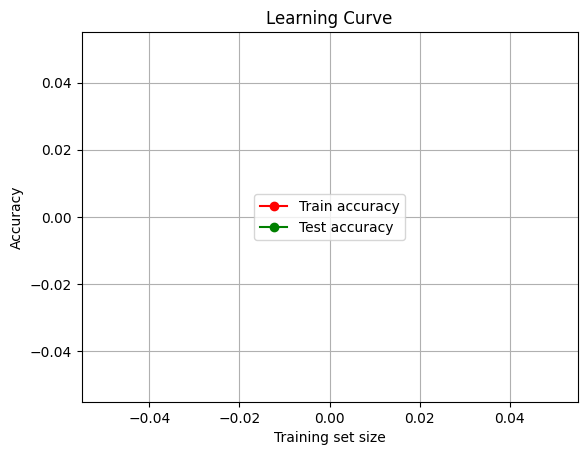

In [275]:
train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, marker = 'o', linestyle = '-', color = 'r', label = "Train accuracy")
plt.plot(train_sizes, valid_errors, marker = 'o', linestyle = '-', color = 'g', label = "Test accuracy")
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc = 10)
plt.grid(True)
plt.show()

## Grid Search (Fitting Hyperparameters)

In [151]:
# print(np.logspace(-4.5, -2.5, num = 5))
def print_progress(estimator):
    # Access the hyperparameters and performance metrics
    print(f"Hyperparameters: {estimator}")
#    print(f"Mean Test Score: {mean_test_score}\n")

In [155]:
from sklearn.model_selection import GridSearchCV

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model(learning_rate = project_learning_rate):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
#    learning_rate = project_learning_rate
#    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
#        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'])
    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, loss = True)
scoring = {'accuracy': 'accuracy'}

# Create a pipeline with scaling and NN model
pipe = Pipeline([
    ('clf', clf) # This will fit the NN model
])

param_grid = {'epochs': [10], # Number of epochs to train the model
              'optimizer': [tf.keras.optimizers.Adam()],
# 1st evaluation (the best result is 0.001, 128
              'optimizer__learning_rate': np.logspace(-4.5, -2.5, num = 5),
#              'optimizer__learning_rate': [0.001, 0.0005, 0.0001],
#              'optimizer__learning_rate': [0.001],
# 2nd evaluation
#              'optimizer__learning_rate': [0.0005, 0.001, 0.002, 0.005],
              'batch_size': [16, 32]
#              'batch_size': [32, 64, 128]
#              'batch_size': [128]
             }

#gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = scoring, refit = 'accuracy', cv = 3, n_jobs = -1, return_train_score = True)
gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = scoring, refit = 'accuracy', cv = 3, n_jobs = 3, return_train_score = True)

# Fit the grid search on the training data
gs.fit(X_train, y_train)

# Print the best parameters and score
print(gs.best_params_)
print(gs.best_score_)

C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/10
1298/1298 [==============================] - 307s 225ms/step - loss: 1.0980 - accuracy: 0.5512
Epoch 2/10
1298/1298 [==============================] - 291s 224ms/step - loss: 0.8968 - accuracy: 0.6401
Epoch 3/10
1298/1298 [==============================] - 287s 221ms/step - loss: 0.8234 - accuracy: 0.6689
Epoch 4/10
1298/1298 [==============================] - 290s 224ms/step - loss: 0.7770 - accuracy: 0.6870
Epoch 5/10
1298/1298 [==============================] - 286s 221ms/step - loss: 0.7477 - accuracy: 0.6955
Epoch 6/10
1298/1298 [==============================] - 289s 223ms/step - loss: 0.7170 - accuracy: 0.7109
Epoch 7/10
1298/1298 [==============================] - 286s 220ms/step - loss: 0.6910 - accuracy: 0.7214
Epoch 8/10
1298/1298 [==============================] - 288s 222ms/step - loss: 0.6753 - accuracy: 0.7256
Epoch 9/10
1298/1298 [==============================] - 287s 221ms/step - loss: 0.6513 - accuracy: 0.7378
Epoch 10/10
1298/1298 [=======================

In [156]:
y_pred = gs.predict(X_test)
print(gs.best_params_)
cv_res = pd.DataFrame(gs.cv_results_)
print(cv_res)

145/145 [==============================] - 9s 56ms/step
{'batch_size': 16, 'epochs': 10, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x00000203FC45EDC0>, 'optimizer__learning_rate': 0.00031622776601683794}
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1121.204904     10.756341        16.733300        2.246026   
1    1090.359721     45.644316        19.718237        0.876697   
2    1144.688543     48.337322        21.463513        2.812522   
3    1242.343029     21.219714        23.937072        1.150991   
4    1371.105835    147.359112        24.204838        1.742754   
5    1235.421621     86.279658        23.373551        5.538391   
6     999.700475    457.305583        19.294147        6.882664   
7     774.223453     19.518219        13.748123        1.263682   
8     859.458888     98.183718        16.412080        1.326601   
9     944.693175    210.041841        14.694798        1.067201   

  param_batch_size param_epochs  \
0         

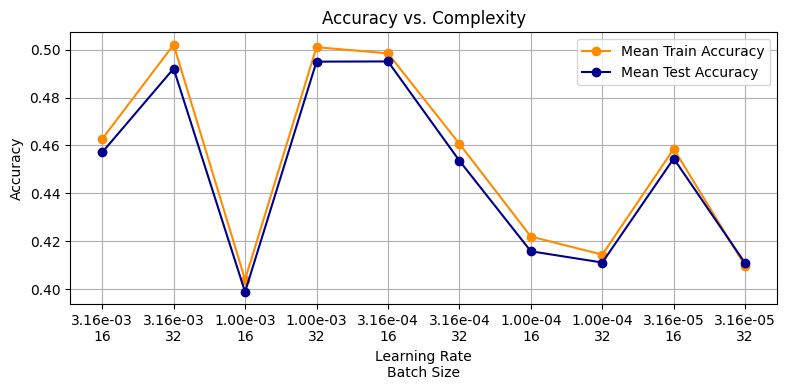

In [226]:
def plot_train_test_accuracy(cv_res):
    df_picture = []
    df_picture = cv_res[['mean_train_accuracy', 'mean_test_accuracy', 'param_batch_size', 'param_optimizer__learning_rate']].copy()
    df_picture['x_labels'] = cv_res['param_optimizer__learning_rate'].apply(lambda x: f"{x:.2e}") + '\n' + cv_res['param_batch_size'].astype(str)
    df_picture.sort_values(by = ['param_optimizer__learning_rate', 'param_batch_size'], ascending = [False, True], inplace = True)
    df_picture.reset_index(drop = True, inplace = True)
 
    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)  # Set width: 12 inches, height: 8 inches

    # Plot mean_train_accuracy
    ax.plot(df_picture.index, df_picture['mean_train_accuracy'], label = 'Mean Train Accuracy', color = 'darkorange', marker = 'o')
    
    # Plot mean_test_accuracy
    ax.plot(df_picture.index, df_picture['mean_test_accuracy'], label = 'Mean Test Accuracy', color = 'darkblue', marker = 'o')
    
    # Set x-axis labels
    ax.set_xticks(df_picture.index)
    ax.set_xticklabels(df_picture['x_labels'], rotation = 0, ha = 'center')  # Rotate labels for readability
    
    # Set labels and title
    ax.set_xlabel('Learning Rate\nBatch Size', ha = 'center')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs. Complexity')
    ax.grid(True)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_train_test_accuracy(cv_res)

In [158]:
clf.set_params(**gs.best_params_)


KerasClassifier(
	model=<function create_model at 0x0000020401B62430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.src.optimizers.adam.Adam object at 0x00000203FC45EDC0>
	loss=True
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
	optimizer__learning_rate=0.00031622776601683794
)

In [157]:
print(np.logspace(-4.5, -2.5, num = 5))

[3.16227766e-05 1.00000000e-04 3.16227766e-04 1.00000000e-03
 3.16227766e-03]


In [ ]:
train_errors = train_scores.mean(axis = 1)
valid_errors = valid_scores.mean(axis = 1)
plt.plot(train_sizes, train_errors, "r-+", linewidth = 2, label = "train")
plt.plot(train_sizes, valid_errors, "b-", linewidth = 3, label = "test")
plt.show()

### Model Compilation

In [231]:
# training method "sgd" means that the model will be trained
# using stochastic gradient descent
# learning_rate is 0.001 (defaults learning rate is 0.01)
learning_rate = 0.00032
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
epochs = 20

#model.compile(
#    optimizer = Adamar,
#    loss = "sparse_categorical_crossentropy",
#    metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None), 'f1'])

def create_model(learning_rate = project_learning_rate, optimizer = Adamar):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
    learning_rate = learning_rate
    
    model.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None), 'f1'])
    return model

create_model(learning_rate, Adamar)
acc_loss = model.fit(
    data_train,
    epochs = epochs,
    validation_data = data_test)

Epoch 1/20
649/649 [==============================] - 143s 220ms/step - loss: 0.9758 - accuracy: 0.5956 - top_2_acc: 0.8312 - val_loss: 1.5337 - val_accuracy: 0.3179 - val_top_2_acc: 0.5575
Epoch 2/20
649/649 [==============================] - 137s 212ms/step - loss: 0.8192 - accuracy: 0.6635 - top_2_acc: 0.8691 - val_loss: 2.7334 - val_accuracy: 0.4027 - val_top_2_acc: 0.6678
Epoch 3/20
649/649 [==============================] - 138s 212ms/step - loss: 0.7546 - accuracy: 0.6868 - top_2_acc: 0.8892 - val_loss: 1.4581 - val_accuracy: 0.4451 - val_top_2_acc: 0.7171
Epoch 4/20
649/649 [==============================] - 139s 214ms/step - loss: 0.7203 - accuracy: 0.7015 - top_2_acc: 0.8930 - val_loss: 1.6698 - val_accuracy: 0.4870 - val_top_2_acc: 0.6990
Epoch 5/20
649/649 [==============================] - 146s 226ms/step - loss: 0.6853 - accuracy: 0.7175 - top_2_acc: 0.8995 - val_loss: 3.3668 - val_accuracy: 0.3261 - val_top_2_acc: 0.5411
Epoch 6/20
649/649 [==============================

In [270]:
learning_rate = 0.00032
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
epochs = 20

clf = KerasClassifier(model = create_model, epochs = epochs, learning_rate = learning_rate,
                      batch_size = 16, loss = True)
clf.fit(X_train, y_train)

Epoch 1/20


TypeError: in user code:

    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\training.py", line 1131, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\training.py", line 1225, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\olgat\OneDrive\PYTHON\ML\nnw\lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [268]:
y_train

[0,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 2,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 4,
 3,
 1,
 0,
 1,
 3,
 3,
 4,
 3,
 0,
 2,
 4,
 3,
 3,
 1,
 3,
 1,
 3,
 0,
 2,
 1,
 2,
 4,
 0,
 3,
 3,
 2,
 0,
 1,
 4,
 1,
 0,
 0,
 2,
 4,
 3,
 2,
 3,
 1,
 4,
 2,
 2,
 0,
 4,
 3,
 2,
 0,
 3,
 4,
 0,
 0,
 0,
 0,
 3,
 1,
 4,
 0,
 4,
 2,
 4,
 4,
 3,
 4,
 2,
 3,
 0,
 4,
 2,
 3,
 0,
 3,
 4,
 4,
 1,
 2,
 1,
 3,
 2,
 2,
 0,
 4,
 2,
 2,
 4,
 4,
 0,
 2,
 4,
 0,
 4,
 4,
 4,
 2,
 3,
 2,
 4,
 3,
 0,
 3,
 2,
 3,
 1,
 4,
 3,
 4,
 2,
 3,
 2,
 0,
 3,
 4,
 0,
 1,
 3,
 2,
 3,
 0,
 0,
 1,
 1,
 3,
 1,
 2,
 0,
 0,
 3,
 4,
 4,
 2,
 2,
 0,
 3,
 3,
 4,
 4,
 0,
 2,
 2,
 0,
 2,
 4,
 4,
 1,
 4,
 3,
 0,
 3,
 2,
 2,
 4,
 4,
 1,
 1,
 3,
 1,
 2,
 2,
 4,
 0,
 4,
 1,
 0,
 3,
 4,
 2,
 4,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 4,
 1,
 2,
 1,
 0,
 0,
 3,
 2,
 1,
 3,
 2,
 4,
 2,
 2,
 3,
 0,
 4,
 0,
 2,
 1,
 4,
 1,
 4,
 2,
 1,
 0,
 4,
 3,
 3,
 1,
 4,
 2,
 2,
 1,
 1,
 3,
 3,
 1,
 2,
 4,
 2,
 3,
 3,
 4,
 3,
 0,
 0,
 1,
 4,
 4,
 3,
 1,
 1,
 4,
 0,
 4,
 0,
 3,
 3,
 4,
 0,


In [256]:
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffling and creating batches from the datasets
data_test = data_test.shuffle(buffer_size = len(X_test)).batch(16)

# Prefetching samples in GPU memory helps maximize GPU utilization.
data_test = data_test.prefetch(tf.data.AUTOTUNE)

In [260]:
y_pred = model.predict(data_test)

AttributeError: 'History' object has no attribute 'predict'

In [258]:
y_pred_labels = np.argmax(y_pred, axis = 1)

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_labels))

# Classification report includes precision,
# recall, f1-score, and the number of actual occurrences
print('Classification Report')

# y_test
print(classification_report(y_test, y_pred_labels))

Confusion Matrix
[[ 39  47  36  50 260]
 [ 41  55  42  53 261]
 [ 52  46  47  68 279]
 [ 47  43  39  63 300]
 [ 60  47  39  43 255]]
Classification Report
              precision    recall  f1-score   support

           0       0.16      0.09      0.12       432
           1       0.23      0.12      0.16       452
           2       0.23      0.10      0.14       492
           3       0.23      0.13      0.16       492
           4       0.19      0.57      0.28       444

    accuracy                           0.20      2312
   macro avg       0.21      0.20      0.17      2312
weighted avg       0.21      0.20      0.17      2312



In [259]:
print(y_pred_labels)
print(y_pred)
print(y_test)

[3 1 4 ... 4 4 2]
[[5.6171073e-03 8.8696589e-04 1.5461695e-04 9.8743409e-01 5.9072161e-03]
 [1.6778437e-02 5.1784587e-01 8.3007468e-03 2.9261711e-01 1.6445780e-01]
 [6.6381554e-06 3.9981585e-03 5.1977247e-05 6.9388910e-04 9.9524927e-01]
 ...
 [5.3183518e-02 4.4928975e-02 4.9384736e-04 1.7005098e-03 8.9969319e-01]
 [1.3553382e-06 1.8055998e-05 5.8164251e-09 1.8556591e-06 9.9997878e-01]
 [3.2414508e-01 1.4690729e-02 4.6003625e-01 2.0064759e-01 4.8044516e-04]]
[4, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 0, 0, 4, 4, 0, 0, 2, 4, 3, 0, 1, 4, 0, 4, 0, 4, 2, 1, 2, 0, 0, 1, 3, 0, 4, 3, 3, 3, 2, 4, 2, 2, 2, 3, 2, 3, 0, 0, 3, 1, 0, 3, 0, 4, 2, 4, 3, 1, 0, 1, 4, 2, 2, 4, 1, 0, 1, 3, 0, 1, 0, 2, 1, 1, 3, 0, 3, 2, 4, 1, 0, 4, 4, 4, 3, 0, 4, 1, 4, 2, 3, 1, 3, 3, 3, 0, 1, 1, 0, 0, 2, 2, 1, 4, 3, 4, 2, 3, 2, 4, 4, 2, 2, 4, 1, 3, 3, 2, 4, 4, 2, 3, 3, 0, 0, 0, 4, 1, 2, 0, 0, 2, 4, 3, 1, 1, 4, 4, 0, 2, 1, 0, 0, 1, 4, 2, 0, 2, 3, 2, 4, 3, 0, 3, 2, 4, 3, 1, 1, 4, 1, 0, 1, 3, 2, 0, 4, 2, 1, 1, 3, 0, 1, 4, 1, 1, 3, 1, 